# Potatoe Diseases Classification with CNN: Full Dataset

## 1. Create the path of dataset
The total datasets are 2152 pictures where:
1. Early blight folder contains 1000 pictures.
2. Healthy leaves folder contains 152 pictures.
3. Late blight folder contains 1000 pictures

In [1]:
data_dir = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/potato"

## 2. Load dataset into TensorFlow then split into training and validation sets

In [2]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    validation_split=0.2,   # 80% train / 20% val
    subset="training",
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)
class_names = train_ds.class_names
num_classes = len(class_names)


Found 2152 files belonging to 3 classes.
Using 1722 files for training.


## 3. Normalize and Augmented the dataset

In [6]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),          # normalize images
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))  # just normalize val set

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


## 4. Create CNN model

In [8]:
from tensorflow.keras import layers, models

def make_simple_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#num_classes = len(train_ds.class_names)
model = make_simple_cnn(IMG_SIZE + (3,), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,051 (14.14 MB)

 Trainable params: 3,706,051 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the CNN model

In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.5298 - loss: 0.9440 - val_accuracy: 0.4233 - val_loss: 1.2141
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.7992 - loss: 0.5249 - val_accuracy: 0.4837 - val_loss: 1.4072
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.8444 - loss: 0.4270 - val_accuracy: 0.4837 - val_loss: 1.6746
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.9018 - loss: 0.2577 - val_accuracy: 0.4837 - val_loss: 2.2630
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.9142 - loss: 0.2252 - val_accuracy: 0.4837 - val_loss: 2.1597
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9080 - loss: 0.2338 - val_accuracy: 0.4233 - val_loss: 2.1164


## 6. Evaluate the model

In [10]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.3f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4061 - loss: 1.2560 
Validation accuracy: 0.423


## 7. Plotting the curve

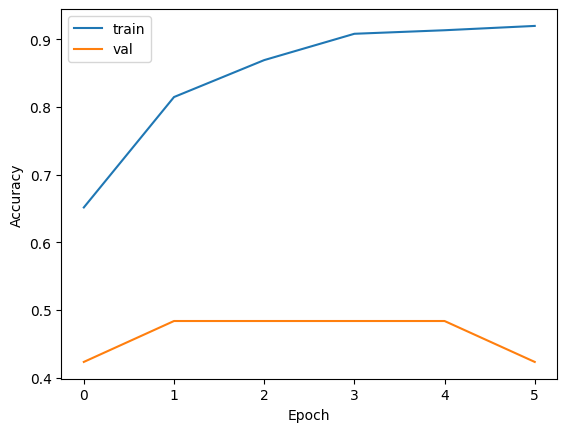

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


## 8. Make predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


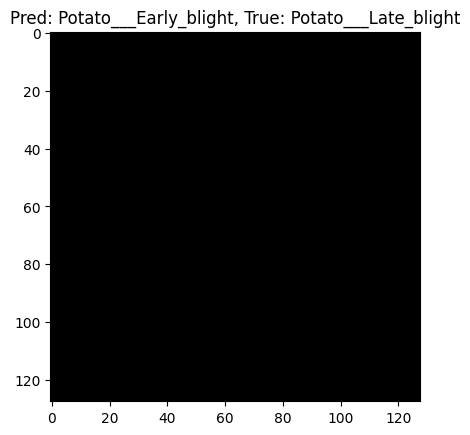

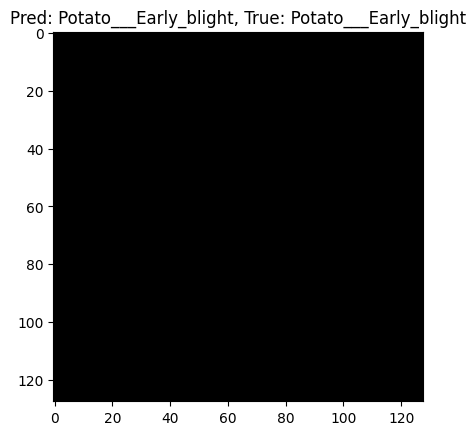

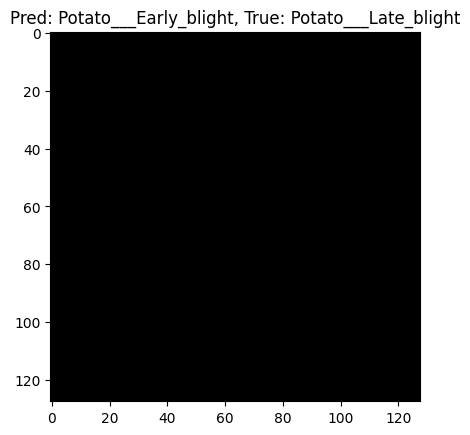

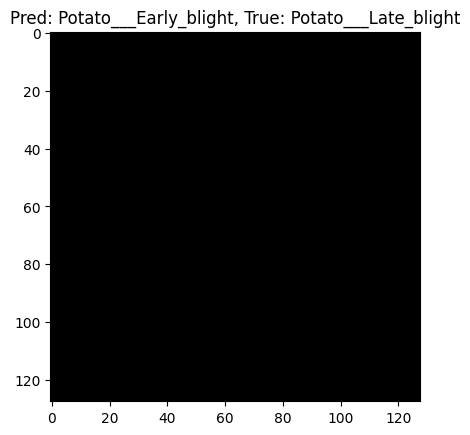

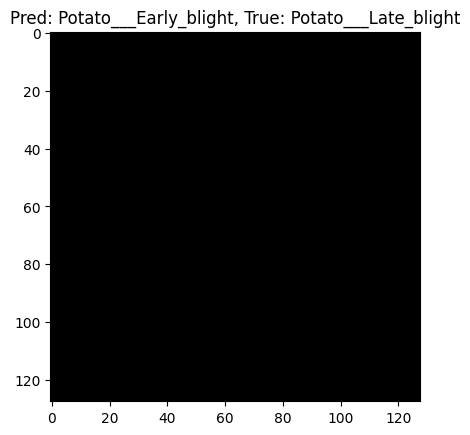

In [13]:
import numpy as np

#class_names = train_ds.class_names

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    for i in range(5):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[np.argmax(preds[i])]}, True: {class_names[np.argmax(labels[i])]}")
        plt.show()


## 9. Conclusion
1. The train accuration is 0.9.. meanwhile the validation accuration is 0.4... This is the sign of overfitting. The cause of this overfitting is the number of healthy picture only 152 meanwhile the two other groups are 1000 each.
2. The first solution by using the augmented technique to increase the number of healthy leaves from 152 to 1000.